In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torch.optim import Adam
from torchvision.datasets import CelebA
from torchvision import transforms
import matplotlib.pyplot as plt

/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <459875AA-DE2C-366B-9C44-90D4B3887080> /Users/muhammadwaseem/miniconda3/envs/torch/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


## Aim
- Play around tweeking hyperparameters - lambda
- Performance with different optimizers
- Performance on usage of image augmentation as I will use small subset to train 
- Change Architecture

## Results:
- ❌
- ❌
- For the case of Eye Glass classification, even without data augmentation, and even with less train data, model generalises quickly. 
- ❌

In [2]:
device = torch.device('mps')

## Data Loading

In [3]:
image_path = './'
celeb_train = CelebA(
                                root= image_path,
                                split='train',
                                target_type='attr', 
                                download=False)

Actual size is 162770, but I will use small subset to train

In [4]:
len(celeb_train)

162770

All 40 attributes are loaded. I need only the attribute specific to wearing eye glass or not

In [5]:
celeb_train.attr.shape

torch.Size([162770, 40])

In [6]:
celeb_train.attr[:,15].shape

torch.Size([162770])

In [69]:
glass = lambda attr: attr[15]

####  Proper loading of data

In [70]:
# transform_train = transforms.Compose([
#                                                 transforms.ToTensor(),
#                                                 transforms.Resize([64, 64]),
#                                           ])
transform_label = transforms.Compose([
                                                transforms.Lambda(glass),
                                          ])

In [71]:
transform_train = transforms.Compose([
    transforms.RandomCrop([178, 178]),
    transforms.RandomHorizontalFlip(),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.CenterCrop([178, 178]),
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])

In [72]:
celeb_train = CelebA( 
                     root=image_path, 
                     split='train',
                     target_type='attr', 
                     transform = transform_train,
                     target_transform = transform_label,
                     download = False
)
celeb_valid = CelebA( 
                     root=image_path, 
                     split='valid',
                     target_type='attr', 
                     transform = transform,
                     target_transform = transform_label,
                     download = False
)
celeb_test = CelebA( 
                     root=image_path, 
                     split='test',
                     target_type='attr', 
                     transform = transform,
                     target_transform = transform_label,
                     download = False
)

In [74]:
len(celeb_train), len(celeb_valid), len(celeb_test)

(162770, 19867, 19962)

#### To minimize computation, I will be using subset of train data and validation data for training and valdiation

In [117]:
train_data = Subset(celeb_train, torch.arange(16000))
validation_data = Subset(celeb_valid, torch.arange(1000))

In [118]:
len(train_data)

16000

In [119]:
train_data[0][0].shape, train_data[0][1]

(torch.Size([3, 64, 64]), tensor(0))

## Visualize train data

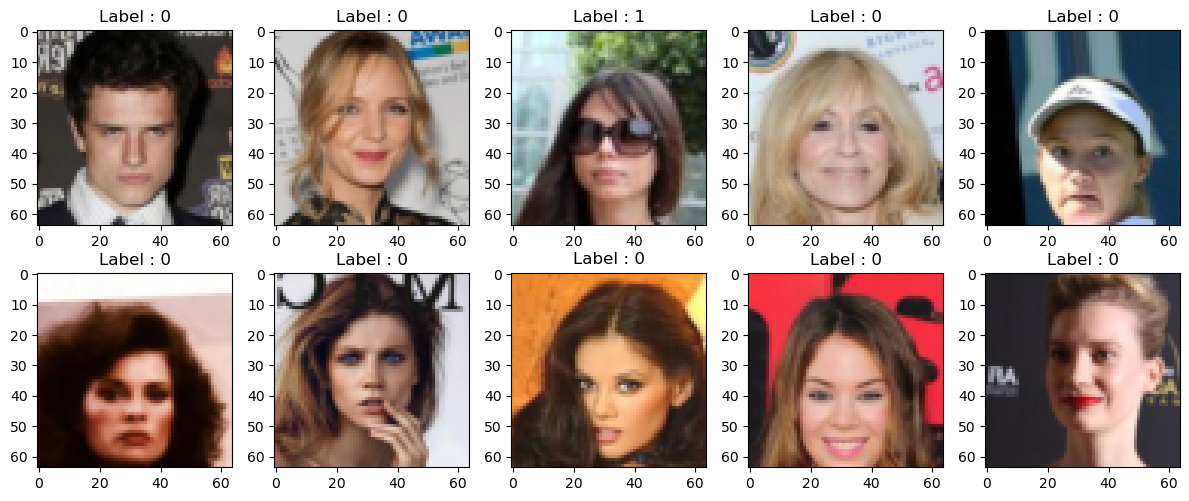

In [120]:
size = 10
plt.figure(figsize=(12,5))
for i in range(90, 90+size):
    plt.subplot(2,5,i+1 - 90)
    plt.title(f"Label : {train_data[i][1].item()}")
    plt.imshow(train_data[i][0].permute(1,2,0))
plt.tight_layout()

## Initialize DataLoader

In [138]:
torch.manual_seed(1)
batch_size = 32
data = DataLoader(train_data, batch_size, shuffle=True)
data_vl = DataLoader(validation_data, batch_size, shuffle=False)

In [139]:
next(iter(data))[0].shape, next(iter(data))[1].shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [140]:
len(data.dataset)

16000

## Model

In [141]:
model = nn.Sequential()
model.add_module("conv1", nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1))
model.add_module("relu1", nn.ReLU())
model.add_module("pool1", nn.MaxPool2d(kernel_size=2)) # stride = pool size by default. --> output dim = 32 * 32
model.add_module("drop1", nn.Dropout(p=0.5))
model.add_module("conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1))
model.add_module("relu2", nn.ReLU())
model.add_module("pool2", nn.MaxPool2d(kernel_size=2)) # --> output dim = 16 * 16
model.add_module("drop2", nn.Dropout(p=0.5))
model.add_module("conv3", nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1))
model.add_module("relu3", nn.ReLU())
model.add_module("pool3", nn.MaxPool2d(kernel_size=2)) # --> output dim = 8 * 8
model.add_module("conv4", nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1))
model.add_module("relu4", nn.ReLU())
model.add_module("avgpool", nn.AvgPool2d(kernel_size=8))
model.add_module("flatten", nn.Flatten(1))
model.add_module("fc1", nn.Linear(256,1))
model.add_module("sigmoid", nn.Sigmoid())

model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.5, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout(p=0.5, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (avgpool): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [142]:
model = model.to(device)

In [143]:
loss_fn = nn.BCELoss() # Where probability is the input
optimizer = Adam(model.parameters(), lr=0.3)

## Training

In [144]:
def train(model, epoch, data, data_vl):
    train_loss = [0] * epoch
    train_accuracy = [0]  * epoch
    valid_loss = [0] * epoch
    valid_accuracy = [0] * epoch
    for i in range(epoch):
        model.train()
        for x_batch, y_batch in data:
            x_batch = x_batch.to(device)
            y_batch = y_batch.reshape(-1,1).float().to(device)
            pred = model(x_batch) # Sigmoid outputs
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i]  += loss.item() * x_batch.size(0)
            is_crt = (torch.where(pred >= 0.5, 1, 0) == y_batch).to(torch.float32).sum().cpu() # very important to transfer to cpu & have torch.float32
            train_accuracy[i] += is_crt
        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.reshape(-1,1).float().to(device)
                pred = model(x_batch) # Sigmoid outputs
                loss = loss_fn(pred, y_batch)
                valid_loss[i]  += loss.item() * x_batch.size(0)
                is_crt = (torch.where(pred >= 0.5, 1, 0) == y_batch).to(torch.float32).sum().cpu()
                valid_accuracy[i] += is_crt.item()
            train_loss[i] /= len(data.dataset)
            train_accuracy[i] /= len(data.dataset)

        valid_loss[i] /= len(data_vl.dataset)
        valid_accuracy[i] /= len(data_vl.dataset)
        print(f'Epoch {i+1} accuracy: {train_accuracy[i]:.4f} val_accuracy:{valid_accuracy[i]:.4f}')
    return train_loss, train_accuracy, valid_loss, valid_accuracy

In [145]:
torch.manual_seed(1)
epoch = 30
train_loss, train_accuracy, valid_loss, valid_accuracy = train(model, epoch, data, data_vl)

Epoch 1 accuracy: 0.9341 val_accuracy:0.9150
Epoch 2 accuracy: 0.9341 val_accuracy:0.9150
Epoch 3 accuracy: 0.9341 val_accuracy:0.9150
Epoch 4 accuracy: 0.9341 val_accuracy:0.9150
Epoch 5 accuracy: 0.9341 val_accuracy:0.9150
Epoch 6 accuracy: 0.9341 val_accuracy:0.9150
Epoch 7 accuracy: 0.9341 val_accuracy:0.9150
Epoch 8 accuracy: 0.9341 val_accuracy:0.9150
Epoch 9 accuracy: 0.9341 val_accuracy:0.9150
Epoch 10 accuracy: 0.9341 val_accuracy:0.9150
Epoch 11 accuracy: 0.9341 val_accuracy:0.9150
Epoch 12 accuracy: 0.9341 val_accuracy:0.9150
Epoch 13 accuracy: 0.9341 val_accuracy:0.9150
Epoch 14 accuracy: 0.9341 val_accuracy:0.9150
Epoch 15 accuracy: 0.9341 val_accuracy:0.9150
Epoch 16 accuracy: 0.9341 val_accuracy:0.9150
Epoch 17 accuracy: 0.9341 val_accuracy:0.9150
Epoch 18 accuracy: 0.9341 val_accuracy:0.9150
Epoch 19 accuracy: 0.9341 val_accuracy:0.9150
Epoch 20 accuracy: 0.9341 val_accuracy:0.9150
Epoch 21 accuracy: 0.9341 val_accuracy:0.9150
Epoch 22 accuracy: 0.9341 val_accuracy:0.91

## Visualisation

In [99]:
import numpy as np

In [100]:
def visualise(epoch, train_accuracy, valid_accuracy, train_loss, valid_loss):
    fig = plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(np.arange(epoch), np.array(train_accuracy), "-o")
    plt.plot(np.arange(epoch), np.array(valid_accuracy), "--<")
    plt.xlabel("$Epoch$")
    plt.title("Accuracy")
    plt.legend(["Train", "Validation"])
    plt.plot()

    plt.subplot(1,2,2)
    plt.plot(np.arange(epoch), np.array(train_loss), "-o")
    plt.plot(np.arange(epoch), np.array(valid_loss), "--<")
    plt.xlabel("$Epoch$")
    plt.title("Loss")
    plt.legend(["Train", "Validation"])

## Observation

#### 1. When no data augmentation performed and using small subset(16000) of data to train
- Higher Accuracy is quickly achieved, but that is not the case while smile classification
- Even test accuracy is high

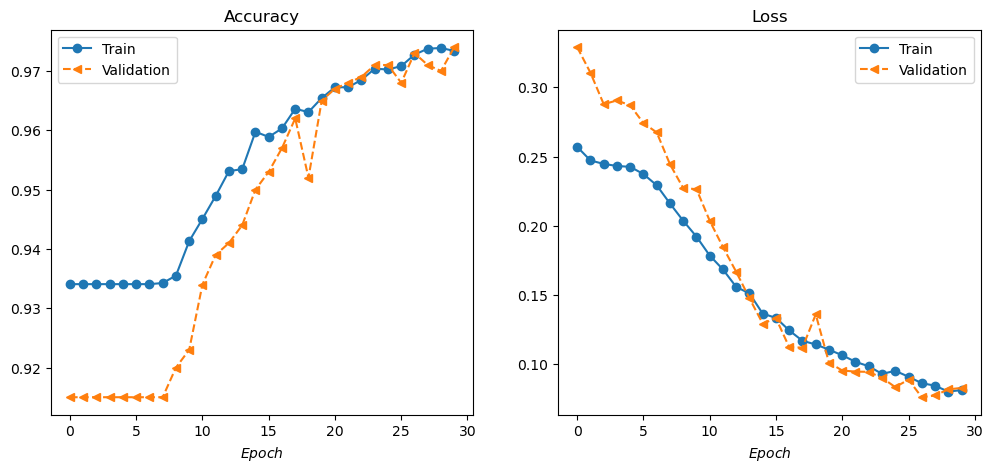

In [101]:
visualise(epoch, train_accuracy, valid_accuracy, train_loss, valid_loss)

In [102]:
data_test = DataLoader(celeb_test, 64)
model.eval()
is_crt = 0
for x_batch, y_batch in data_test:
    x_batch = x_batch.to(device)
    y_batch = y_batch.reshape(-1,1).float().to(device)
    pred = model(x_batch) 
    is_crt+= (torch.where(pred>=0.5, 1, 0) == y_batch).to(torch.float32).sum().cpu()
print(f"Accuracy: {is_crt/len(data_test.dataset)}")    

Accuracy: 0.9780082106590271


#### 1. When no data augmentation performed and using small subset(1000) of data to train
- Higher Accuracy is quickly achieved, but that is not the case while smile classification
- Weirdly accuracy is same, but loss changes
- Still with less data, getting 93% accuracy

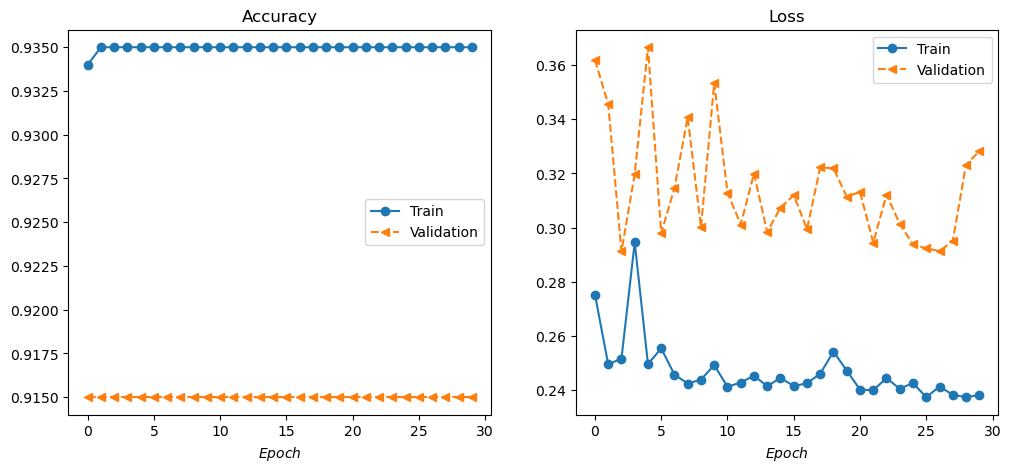

In [115]:
visualise(epoch, train_accuracy, valid_accuracy, train_loss, valid_loss)

In [116]:
data_test = DataLoader(celeb_test, 64)
model.eval()
is_crt = 0
for x_batch, y_batch in data_test:
    x_batch = x_batch.to(device)
    y_batch = y_batch.reshape(-1,1).float().to(device)
    pred = model(x_batch) 
    is_crt+= (torch.where(pred>=0.5, 1, 0) == y_batch).to(torch.float32).sum().cpu()
print(f"Accuracy: {is_crt/len(data_test.dataset)}")    

Accuracy: 0.9354273080825806


#### 3. Using small subset(16000) of data to train and very less (0.0001) learning rate

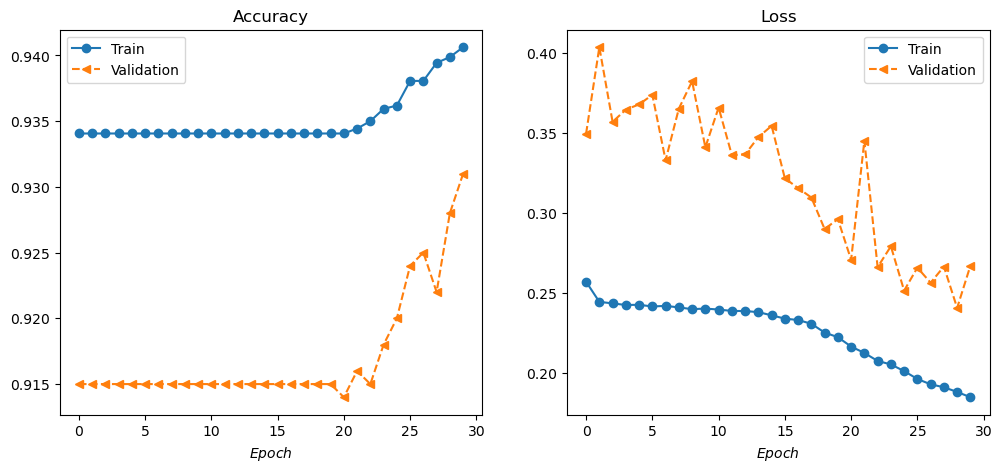

In [129]:
visualise(epoch, train_accuracy, valid_accuracy, train_loss, valid_loss)

In [130]:
data_test = DataLoader(celeb_test, 64)
model.eval()
is_crt = 0
for x_batch, y_batch in data_test:
    x_batch = x_batch.to(device)
    y_batch = y_batch.reshape(-1,1).float().to(device)
    pred = model(x_batch) 
    is_crt+= (torch.where(pred>=0.5, 1, 0) == y_batch).to(torch.float32).sum().cpu()
print(f"Accuracy: {is_crt/len(data_test.dataset)}")    

Accuracy: 0.945997416973114


#### 4. Using small subset(16000) of data to train and higher (0.06) learning rate
- No improvement in model.

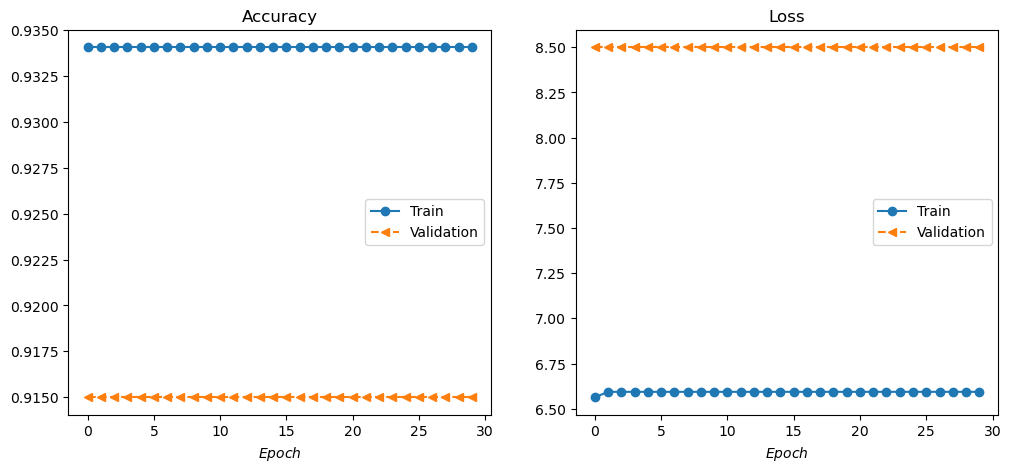

In [146]:
visualise(epoch, train_accuracy, valid_accuracy, train_loss, valid_loss)

In [147]:
data_test = DataLoader(celeb_test, 64)
model.eval()
is_crt = 0
for x_batch, y_batch in data_test:
    x_batch = x_batch.to(device)
    y_batch = y_batch.reshape(-1,1).float().to(device)
    pred = model(x_batch) 
    is_crt+= (torch.where(pred>=0.5, 1, 0) == y_batch).to(torch.float32).sum().cpu()
print(f"Accuracy: {is_crt/len(data_test.dataset)}")    

Accuracy: 0.9354273080825806


In [ ]:
x_t = next(iter(data_test))[0]
y_t = next(iter(data_test))[1]

In [ ]:
x_t.shape

In [ ]:
x_t[0].permute(1,2,0).shape

In [ ]:
plt.figure(figsize=(30,15))
for i in range(len(x_t)):
    plt.subplot(8,8,i+1)
    if(y_t[i] ==  1):
        plt.title(f"Label : {y_t[i]}", size=10, c='r')
    else:
        plt.title(f"Label : {y_t[i]}", size=10)
    plt.imshow(x_t[i].permute(1,2,0))
plt.tight_layout()

## Doubts

1. Even with less train data, how does the model quickly learns to classify glasses but not smile??
    - How does the model even generalise with such small dataset?
2. With higher learning rate 0.6, why there isn't a minute change in loss/ accuracy. Should'nt the model overshoot?
    - Weirdly accuracy is same as with lr=0.0001, 